## Lab 5
### Name: Behnam Sobhani Nadri
### Student ID: 801368949

## All libraries that we use in the lab is defined here

In [57]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sb
import torch
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Problem I**
###In our temperature prediction example discussed in class, let’s change our model to a nonlinear system. Consider the following description for our model:

###w2 * t_u ** 2 + w1 * t_u + b

## **Problem I. A**  
###Modify the training loop properly to accommodate this redefinition.





In [58]:
def non_l_model(t_u, params):
    w2, w1, b = params
    return w2 * t_u ** 2+ w1 * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

def training_loop(n_epochs, learning_rate, params, t_u, t_c):

    loss_track = np.zeros((n_epochs,1))

    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
              params.grad.zero_()
        # Forward pass: Compute predicted y by passing x to the model
        t_p = non_l_model(t_u, params)
        # t_p=l_model(t_u,params)

        # Compute and print loss
        loss = loss_fn(t_p, t_c)

        # Zero gradients, perform a backward pass, and update the weights.
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
            params.grad.zero_()  # Reset gradients for next iteration

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')
        loss_track[epoch-1] = loss.item()
    # Final parameters
    # print(f'Final parameters: w2={params[0].item()}, w1={params[1].item()}, b={params[2].item()}')
    return loss_track


In [59]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

t_u_min = t_u.min()
t_u_max = t_u.max()

t_un = (t_u - t_u_min) / (t_u_max - t_u_min)
t_un

tensor([0.2313, 0.5674, 0.6057, 1.0000, 0.5740, 0.4509, 0.2013, 0.0000, 0.4426,
        0.6423, 0.7754])

## **Problem I. B**
###Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss for every 500 epochs per training.





In [60]:

learning_rate = [0.004,0.02,0.08,0.099]
n_epochs = 5000
loss_tr=np.zeros((n_epochs,len(learning_rate)+2))

for i in range(n_epochs):
    loss_tr[i,0]=i+1

i=1
for lr in learning_rate:
      print()
      print (f'Trainings with Learning Rate = {lr}')
      print()
      params = torch.tensor([1.0, 1.0, 0.0],requires_grad=True)
      loss_tr[:,i]= training_loop(n_epochs = 5000,
                        learning_rate = lr,
                        params = torch.tensor([1.0, 1.0, 0.0],requires_grad=True),
                        t_u = t_un,
                        t_c = t_c).squeeze()
      i+=1


Trainings with Learning Rate = 0.004

Epoch 500, Loss 19.66827964782715
Epoch 1000, Loss 9.86706256866455
Epoch 1500, Loss 5.625737190246582
Epoch 2000, Loss 3.7870676517486572
Epoch 2500, Loss 2.9871156215667725
Epoch 3000, Loss 2.636301279067993
Epoch 3500, Loss 2.479783058166504
Epoch 4000, Loss 2.4073994159698486
Epoch 4500, Loss 2.3715269565582275
Epoch 5000, Loss 2.351581335067749

Trainings with Learning Rate = 0.02

Epoch 500, Loss 2.9869890213012695
Epoch 1000, Loss 2.3515725135803223
Epoch 1500, Loss 2.306149959564209
Epoch 2000, Loss 2.274777889251709
Epoch 2500, Loss 2.2480695247650146
Epoch 3000, Loss 2.225238561630249
Epoch 3500, Loss 2.2057197093963623
Epoch 4000, Loss 2.189033269882202
Epoch 4500, Loss 2.1747689247131348
Epoch 5000, Loss 2.162574529647827

Trainings with Learning Rate = 0.08

Epoch 500, Loss 2.274923086166382
Epoch 1000, Loss 2.1890950202941895
Epoch 1500, Loss 2.1432600021362305
Epoch 2000, Loss 2.118778705596924
Epoch 2500, Loss 2.105705499649048
Epo

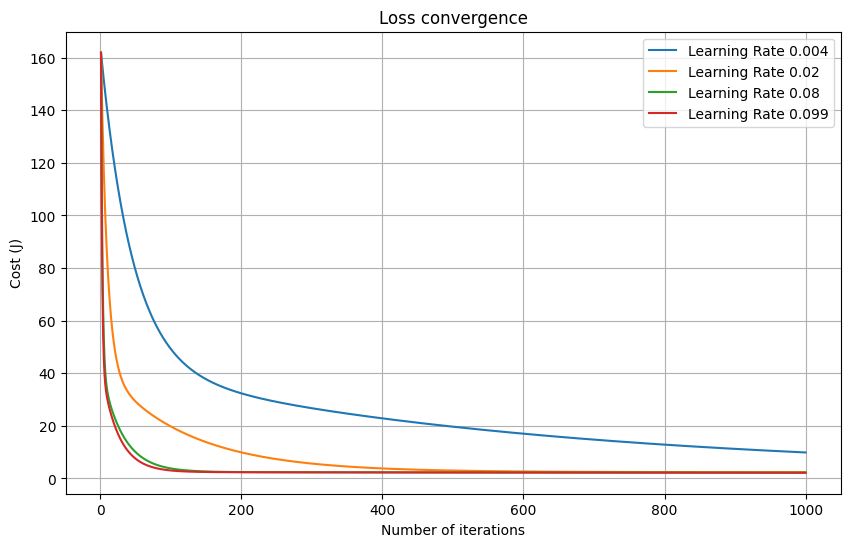

In [61]:
plt.plot(loss_tr[:1000,0], loss_tr[:1000,1],label=f'Learning Rate {learning_rate[0]}')
plt.plot(loss_tr[:1000,0], loss_tr[:1000,2],label=f'Learning Rate {learning_rate[1]}')
plt.plot(loss_tr[:1000,0], loss_tr[:1000,3],label=f'Learning Rate {learning_rate[2]}')
plt.plot(loss_tr[:1000,0], loss_tr[:1000,4],label=f'Learning Rate {learning_rate[3]}')

plt.rcParams["figure.figsize"] = (10,6)
plt.grid(1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost (J)')
plt.title(f'Loss convergence')
plt.legend()

##**Problem I. C**

###Pick the best non-linear model and compare your final best loss against the linear model that we did during the lecture. For this, visualize the non-linear model against the linear model over the input dataset, as we did during the lecture. Is the actual result better or worse than our baseline linear model?

In [62]:
def l_model(t_u,params):
    w, b = params
    return w * t_u + b

In [63]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    loss_track = np.zeros((n_epochs,1))
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
              params.grad.zero_()
        # Forward pass: Compute predicted y by passing x to the model
        t_p=l_model(t_u,params)

        # Compute and print loss
        loss = loss_fn(t_p, t_c)

        # Zero gradients, perform a backward pass, and update the weights.
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
            params.grad.zero_()  # Reset gradients for next iteration

        # if epoch % 500 == 0:
        #     print(f'Epoch {epoch}, Loss {loss.item()}')
        loss_track[epoch-1] = loss.item()
    # Final parameters
    # print(f'Final parameters: w2={params[0].item()}, w1={params[1].item()}, b={params[2].item()}')
    return loss_track

In [64]:

learning_rate = 1e-2
n_epochs = 5000

params = torch.tensor([1.0, 0.0],requires_grad=True)

loss_tr[:,5] = training_loop(n_epochs = 5000,
                  learning_rate = lr,
                  params = torch.tensor([1.0, 0.0],requires_grad=True),
                  t_u = t_un,
                  t_c = t_c).squeeze()

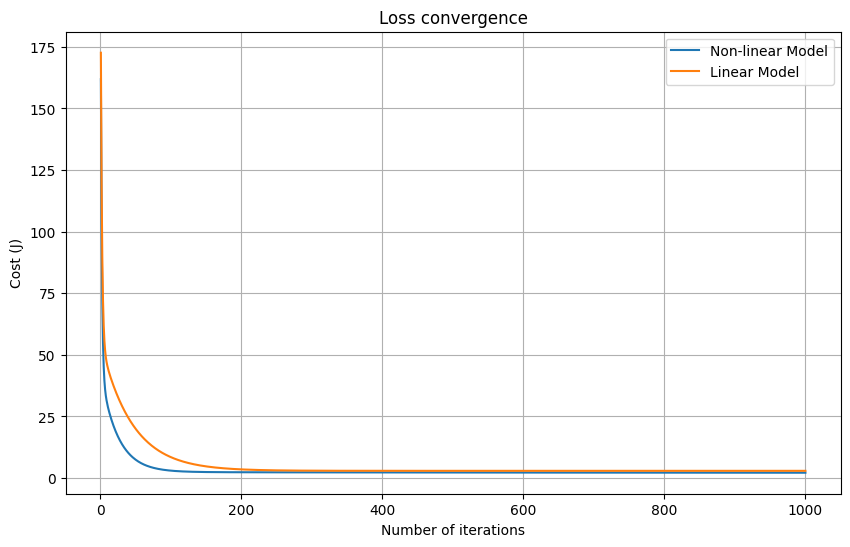

In [65]:

plt.plot(loss_tr[:1000,0], loss_tr[:1000,4],label='Non-linear Model')
plt.plot(loss_tr[:1000,0], loss_tr[:1000,5],label='Linear Model')

plt.rcParams["figure.figsize"] = (10,6)
plt.grid(1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost (J)')
plt.title(f'Loss convergence')
plt.legend()

## **Problem II. A**
### Develop preprocessing and a training loop to train a linear regression model that predicts housing price based on the following input variables:

###area, bedrooms, bathrooms, stories, parking

###For this, you need to use the housing dataset. For training and validation use 80% (training) and 20% (validation) split. Identify the best parameters for your linear regression model, based on the above input variables. In this case, you will have six parameters:





In [78]:
file_path = '/content/drive/My Drive/Courses/Intro to ML/Lab2/Housing.csv'
df_house = pd.read_csv(file_path)
# Select relevant features
features = df_house[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']]
target = df_house['price']

# Convert to torch tensors
features = torch.tensor(features.values, dtype=torch.float32)
target = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)

# Split into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float32)

# Normalize the target variable
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std
y_val = (y_val - y_train_mean) / y_train_std

In [79]:
# Linear model
def l_model(X, params):
    return X @ params[:-1] + params[-1]

# Loss function (mean squared error)
def loss_fn(t_p, t_c):
    return ((t_p - t_c) ** 2).mean()

# Training loop
def training_loop(n_epochs, learning_rate, params, X_train, y_train, X_val, y_val):
    loss_track = np.zeros((n_epochs,1))

    for epoch in range(1, n_epochs + 1):
        # Forward pass: Compute predicted y
        t_p = l_model(X_train, params)

        # Compute loss
        loss = loss_fn(t_p, y_train)

        # Zero gradients, perform a backward pass, and update the weights
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
            params.grad.zero_()

        # Validation loss
        if epoch % 500 == 0 or epoch == 1:
            with torch.no_grad():
                val_loss = loss_fn(l_model(X_val, params), y_val).item()
                print(f"Epoch {epoch}, Training loss {loss.item():.4f}, Validation loss {val_loss:.4f}")

        loss_track[epoch-1] = loss.item()

    return loss_track


## **Problem II. B**
### Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss and validation accuracy for every 500 epochs per training. Pick the best linear model.

In [80]:

learning_rate = [0.004,0.02,0.08,0.099]
n_epochs = 5000

loss_tr = np.zeros((n_epochs,len(learning_rate)+2))

w=torch.ones(())
b=torch.zeros(())


for i in range(n_epochs):
    loss_tr[i,0]=i+1

i=1
for lr in learning_rate:
      print()
      print (f'Trainings with Learning Rate = {lr}')
      print()
      params = torch.randn((6, 1), requires_grad=True)
      loss_tr[:,i]= training_loop(
              n_epochs=5000,
              learning_rate=lr,
              params=params,
              X_train=X_train,
              y_train=y_train,
              X_val=X_val,
              y_val=y_val).squeeze()
      i+=1


Trainings with Learning Rate = 0.004

Epoch 1, Training loss 3.0293, Validation loss 3.0341
Epoch 500, Training loss 0.4459, Validation loss 0.7488
Epoch 1000, Training loss 0.4369, Validation loss 0.7419
Epoch 1500, Training loss 0.4368, Validation loss 0.7419
Epoch 2000, Training loss 0.4368, Validation loss 0.7419
Epoch 2500, Training loss 0.4368, Validation loss 0.7419
Epoch 3000, Training loss 0.4368, Validation loss 0.7419
Epoch 3500, Training loss 0.4368, Validation loss 0.7419
Epoch 4000, Training loss 0.4368, Validation loss 0.7419
Epoch 4500, Training loss 0.4368, Validation loss 0.7419
Epoch 5000, Training loss 0.4368, Validation loss 0.7419

Trainings with Learning Rate = 0.02

Epoch 1, Training loss 15.2088, Validation loss 18.1400
Epoch 500, Training loss 0.4368, Validation loss 0.7419
Epoch 1000, Training loss 0.4368, Validation loss 0.7419
Epoch 1500, Training loss 0.4368, Validation loss 0.7419
Epoch 2000, Training loss 0.4368, Validation loss 0.7419
Epoch 2500, Train

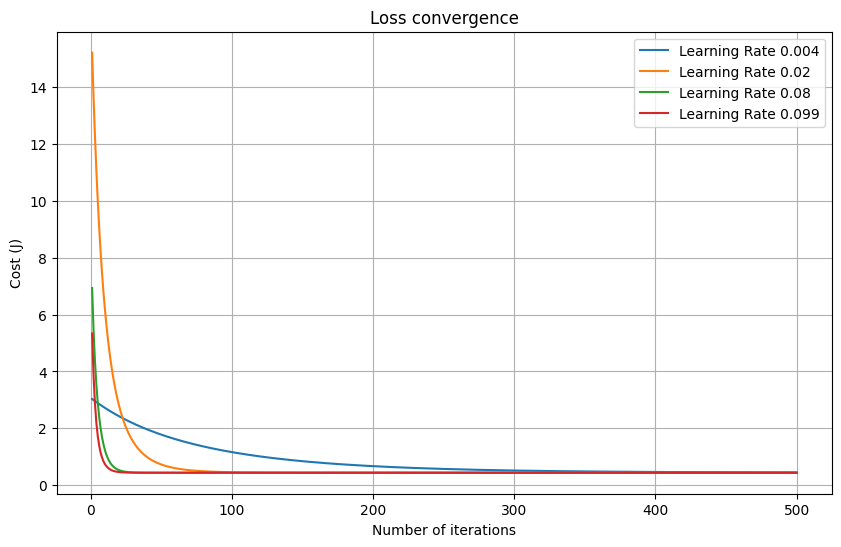

In [81]:
plt.plot(loss_tr[:500,0], loss_tr[:500,1],label=f'Learning Rate {learning_rate[0]}')
plt.plot(loss_tr[:500,0], loss_tr[:500,2],label=f'Learning Rate {learning_rate[1]}')
plt.plot(loss_tr[:500,0], loss_tr[:500,3],label=f'Learning Rate {learning_rate[2]}')
plt.plot(loss_tr[:500,0], loss_tr[:500,4],label=f'Learning Rate {learning_rate[3]}')

plt.rcParams["figure.figsize"] = (10,6)
plt.grid(1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost (J)')
plt.title(f'Loss convergence')
plt.legend()

## **Problem II. C**
### Repeat all sections of problem 2, this time use all the input features from the housing price dataset

In [90]:
file_path = '/content/drive/My Drive/Courses/Intro to ML/Lab2/Housing.csv'
df_house = pd.read_csv(file_path)

df_house_1 = (df_house.iloc[:,[4,5,6,7,8,10]] == 'yes').replace(True,1).replace(False,0)
df_house = pd.concat([df_house.iloc[:,[0,1,2,3,4,10,12]], df_house_1], axis = 1)
df_house_2 = pd.DataFrame((df_house.iloc[:,6] == 'furnished').replace(True,1).replace(False,0)).rename(columns={'furnishingstatus':'furnished'})
df_house = pd.concat([df_house, df_house_2], axis = 1)
df_house_3 = pd.DataFrame((df_house.iloc[:,6] == 'unfurnished').replace(True,1).replace(False,0)).rename(columns={'furnishingstatus':'unfurnished'})
df_house = pd.concat([df_house, df_house_3], axis = 1)
df_house_4 = pd.DataFrame((df_house.iloc[:,6] == 'semi-furnished').replace(True,1).replace(False,0)).rename(columns={'furnishingstatus':'semi-furnished'})
df_house = pd.concat([df_house, df_house_4], axis = 1)
df_house = df_house.drop(['furnishingstatus'],axis=1)

df_house

,price,area,bedrooms,bathrooms,stories,parking,stories,mainroad,guestroom,basement,hotwaterheating,parking,furnished,unfurnished,semi-furnished
0,13300000,7420,4,2,3,2,0,1,0,0,0,0,1,0,0
1,12250000,8960,4,4,4,3,0,1,0,0,0,0,1,0,0
2,12250000,9960,3,2,2,2,0,1,0,1,0,0,0,0,1
3,12215000,7500,4,2,2,3,0,1,0,1,0,0,1,0,0
4,11410000,7420,4,1,2,2,0,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,2,0,1,0,1,0,0,0,1,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,0,0,1,0,0,0,0,0,1,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1,0,0


In [91]:
features = df_house.iloc[:,1:]
target = df_house['price']

# Convert to torch tensors
features = torch.tensor(features.values, dtype=torch.float32)
target = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)

# Split into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float32)

# Normalize the target variable
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std
y_val = (y_val - y_train_mean) / y_train_std

In [92]:

def l_model(X, params):
    return X @ params[:-1] + params[-1]

def loss_fn(t_p, t_c):
    return ((t_p - t_c) ** 2).mean()

# Training loop
def training_loop(n_epochs, learning_rate, params, X_train, y_train, X_val, y_val):
    loss_track = np.zeros((n_epochs,1))

    for epoch in range(1, n_epochs + 1):
        # Forward pass: Compute predicted y
        t_p = l_model(X_train, params)

        # Compute loss
        loss = loss_fn(t_p, y_train)

        # Zero gradients, perform a backward pass, and update the weights
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
            params.grad.zero_()

        # Validation loss
        if epoch % 500 == 0 or epoch == 1:
            with torch.no_grad():
                val_loss = loss_fn(l_model(X_val, params), y_val).item()
                print(f"Epoch {epoch}, Training loss {loss.item():.4f}, Validation loss {val_loss:.4f}")

        loss_track[epoch-1] = loss.item()

    return loss_track


In [93]:

learning_rate = [0.004,0.02,0.08,0.099]
n_epochs = 5000

loss_tr = np.zeros((n_epochs,len(learning_rate)+2))


for i in range(n_epochs):
    loss_tr[i,0]=i+1

i=1
for lr in learning_rate:
      print()
      print (f'Trainings with Learning Rate = {lr}')
      print()
      params = torch.randn((15, 1), requires_grad=True)
      loss_tr[:,i]= training_loop(
              n_epochs=5000,
              learning_rate=lr,
              params=params,
              X_train=X_train,
              y_train=y_train,
              X_val=X_val,
              y_val=y_val).squeeze()
      i+=1


Trainings with Learning Rate = 0.004

Epoch 1, Training loss 22.1877, Validation loss 25.8795
Epoch 500, Training loss 0.4261, Validation loss 0.7553
Epoch 1000, Training loss 0.3691, Validation loss 0.6784
Epoch 1500, Training loss 0.3679, Validation loss 0.6770
Epoch 2000, Training loss 0.3679, Validation loss 0.6771
Epoch 2500, Training loss 0.3679, Validation loss 0.6771
Epoch 3000, Training loss 0.3679, Validation loss 0.6771
Epoch 3500, Training loss 0.3679, Validation loss 0.6771
Epoch 4000, Training loss 0.3679, Validation loss 0.6771
Epoch 4500, Training loss 0.3679, Validation loss 0.6771
Epoch 5000, Training loss 0.3679, Validation loss 0.6771

Trainings with Learning Rate = 0.02

Epoch 1, Training loss 12.1005, Validation loss 10.7239
Epoch 500, Training loss 0.3679, Validation loss 0.6771
Epoch 1000, Training loss 0.3679, Validation loss 0.6771
Epoch 1500, Training loss 0.3679, Validation loss 0.6771
Epoch 2000, Training loss 0.3679, Validation loss 0.6771
Epoch 2500, Tra

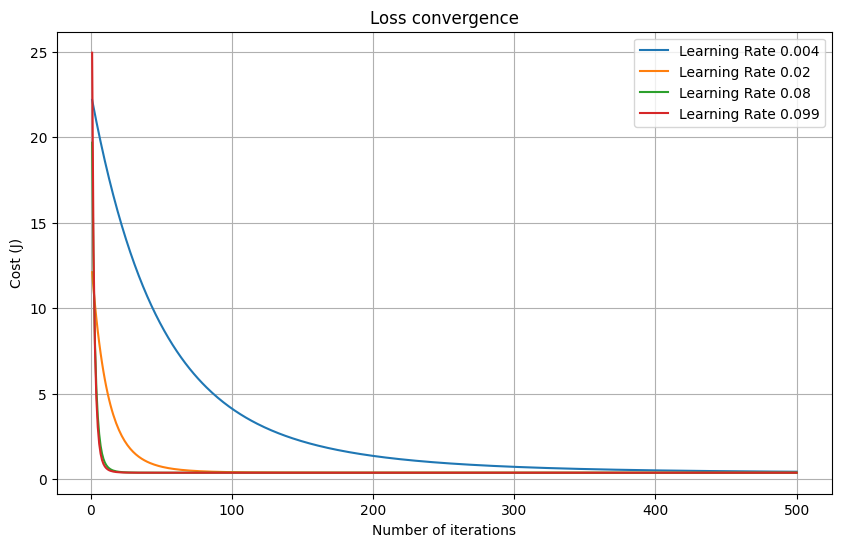

In [94]:
plt.plot(loss_tr[:500,0], loss_tr[:500,1],label=f'Learning Rate {learning_rate[0]}')
plt.plot(loss_tr[:500,0], loss_tr[:500,2],label=f'Learning Rate {learning_rate[1]}')
plt.plot(loss_tr[:500,0], loss_tr[:500,3],label=f'Learning Rate {learning_rate[2]}')
plt.plot(loss_tr[:500,0], loss_tr[:500,4],label=f'Learning Rate {learning_rate[3]}')

plt.rcParams["figure.figsize"] = (10,6)
plt.grid(1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost (J)')
plt.title(f'Loss convergence')
plt.legend()